In [1]:
import itertools
import random
import collections
import os
from datetime import datetime

from scipy.optimize import curve_fit
import numpy as np
import pandas as pd

from community import community_louvain
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})
%matplotlib inline

import plotly
import plotly.graph_objs as pgo

from nxplot_3d import get_trace_nodes_3D_legend
from nxplot_3d import get_trace_edges_3D
from nxplot_3d import plot_3D

from export_import import export_data
from export_import import read_data

from csv_to_network import get_graph

path = "../data/static/"

# Fetch Data & make Network

In [19]:
req = pd.read_csv(path + 'my_req.csv', sep='|', keep_default_na=False)
DG = get_graph(req, cut=0, direction="")
list_node_deg = sorted(list(dict(DG.degree()).items()), key=lambda x: x[1], reverse=True)

# Degree Distribution

/tmp/ipykernel_30438/714574286.py:48: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(k, np.exp(linear(np.log(k), popt[0]+1, popt[1])),\
/tmp/ipykernel_30438/714574286.py:48: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(k, np.exp(linear(np.log(k), popt[0]+1, popt[1])),\
/tmp/ipykernel_30438/714574286.py:48: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(k, np.exp(linear(np.log(k), popt[0]+1, popt[1])),\


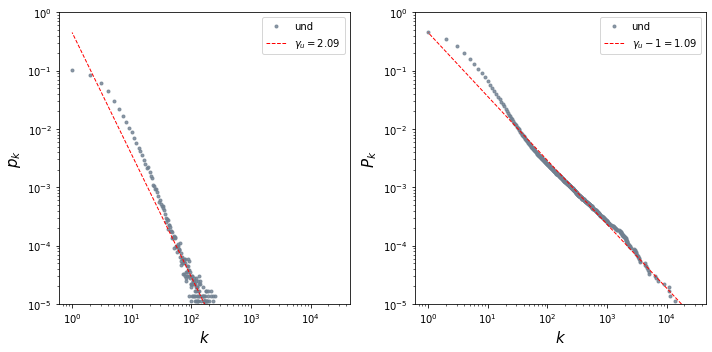

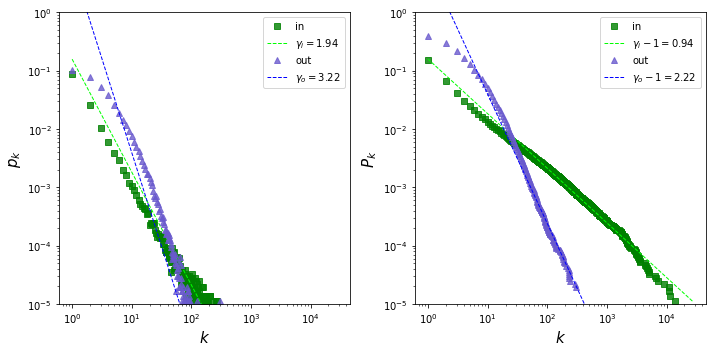

In [57]:
def linear(x, a, ε):
    return -a*x + ε

def curve_fit_log(xdata, ydata):
    xdata_log = np.log(xdata)
    ydata_log = np.log(ydata)
    popt_log, pcov_log = curve_fit(linear, xdata_log, ydata_log)
    ydata_fit = np.exp(linear(xdata_log, *popt_log))
    return (popt_log, pcov_log, ydata_fit)

def get_dist(G, directed=False):
    degree_sequence = sorted(list(dict(G.degree()).values()), reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    k, p_k = zip(*degreeCount.items())
    k = np.array(k)
    p_k = np.array(p_k)/sum(p_k)
    CDD = np.cumsum(p_k)
    if directed==True:
        degree_sequence_in = sorted(list(dict(DG.in_degree()).values()), reverse=True)
        degreeCount_in = collections.Counter(degree_sequence_in)
        k_in, p_k_in = zip(*degreeCount_in.items())
        k_in = np.array(k_in)
        p_k_in = np.array(p_k_in)/sum(p_k_in)
        CDD_in = np.cumsum(p_k_in)
        
        degree_sequence_out = sorted(list(dict(DG.out_degree()).values()), reverse=True)
        degreeCount_out = collections.Counter(degree_sequence_out)
        k_out, p_k_out = zip(*degreeCount_out.items())
        k_out = np.array(k_out)
        p_k_out = np.array(p_k_out)/sum(p_k_out)
        CDD_out = np.cumsum(p_k_out)
        return (k, p_k, CDD), (k_in, p_k_in, CDD_in), (k_out, p_k_out, CDD_out)
    return (k, p_k, CDD)
        
(k, p_k, CDD), (k_in, p_k_in, CDD_in), (k_out, p_k_out, CDD_out) = get_dist(DG, directed=True)

popt, pcov, CDD_fit = curve_fit_log(k[:-1], CDD[:-1])
popt_in, pcov_in, CDD_fit_in = curve_fit_log(k_in[:-1], CDD_in[:-1])
popt_out, pcov_out, CDD_fit_out = curve_fit_log(k_out[:-1], CDD_out[:-1])


def plot_pk_CDD(k, p_k, CDD, CDD_fit, popt,\
                direction="u", node_color='slategrey',\
                alpha=0.8, fit_color='r', marker='.',\
                p_n=[0, 1]):

    ax[0].loglog(k, p_k, marker, alpha=alpha, c=node_color , label=direction)
    ax[0].plot(k, np.exp(linear(np.log(k), popt[0]+1, popt[1])),\
                c=fit_color, lw=1, linestyle='--', label=fr"$γ_{direction[0]} = {round(popt[0], 2)+1}$")
    
    ax[0].set_ylabel(fr'$p_k$', fontsize=15)
    ax[0].set_xlabel(fr'$k$', fontsize=15)
    ax[0].legend(loc='best')
    ax[0].set_ylim((1e-5, 1))
    

    ax[1].loglog(k, CDD, marker, alpha=alpha, c=node_color, label=direction)
    ax[1].loglog(k[:-1], CDD_fit, linestyle='--',c=fit_color, lw=1,\
                             label=fr"$γ_{direction[0]}-1 = {round(popt[0], 2)}$")
    ax[1].legend(loc='best')
    ax[1].set_ylabel(r'$P_k$', fontsize=15)
    ax[1].set_xlabel(r'$k$', fontsize=15)
    ax[1].set_ylim((1e-5, 1))

fig, ax= plt.subplots(1, 2, figsize=[10,  5])
plot_pk_CDD(k, p_k, CDD, CDD_fit, popt, marker='.', direction="und")
fig.tight_layout()
fig.savefig('../pres/pics/dist_u.png', dpi=300)

fig, ax= plt.subplots(1, 2, figsize=[10,  5])
plot_pk_CDD(k_in, p_k_in, CDD_in, CDD_fit_in, popt_in,\
            direction='in', node_color='green', fit_color='lime', marker='s')
plot_pk_CDD(k_out, p_k_out, CDD_out, CDD_fit_out, popt_out,\
            direction='out', node_color='slateblue', fit_color='blue', marker='^')
fig.tight_layout()
fig.savefig('../pres/pics/dist_d.png', dpi=300)

535

# Top nodes

In [9]:
#top = 10
#top_node, top_degree = zip(*(list_node_deg[:top]))
#cc_node, cc_cent = zip(*sorted(list(nx.closeness_centrality(DG).items()),
#                              key=lambda x: x[1], reverse=True)[:top])
#bc_node, bc_cent = zip(*sorted(list(nx.betweenness_centrality(partial_DG).items()),
#                               key=lambda x: x[1], reverse=True)[:top])
#fig, ax = plt.subplots(1, 2, figsize=[14, 8])
#ax[0].barh(top_node, top_degree, height=0.9)
#ax[0].invert_yaxis()
#ax[0].set_title("Degree Centrality", fontsize=18, fontweight='bold')
#
#ax[1].barh(cc_node, cc_cent, height=0.9)
#ax[1].invert_yaxis()
#ax[1].set_title("Closeness Centrality", fontsize=18, fontweight='bold')

#ax[2].barh(bc_node, bc_cent, height=0.9)
#ax[2].invert_yaxis()
#ax[2].set_title("Betweenness Centrality", fontsize=18, fontweight='bold')

#fig.tight_layout()
#fig.savefig('./pres/pics/sneak_peak.png', dpi=300)

In [11]:
#pat_len = dict(nx.shortest_path_length(DG))
#avg_pat_lens = []
#for node in pat_len:
#    avg_pat_lens.append(np.mean(list(pat_len[node].values())))
#    
#avg_pat_lens = [x for x in avg_pat_lens if x!=0.0]
#avg_pat_len = np.mean(avg_pat_lens)

In [280]:
#print(DG)
#print("\n")
#print(f"<k_in^2> = {1/DG.number_of_nodes() *sum(np.array(list(dict(DG.in_degree()).values())) ** 2)}")
#print(f"<k_out^2> = {1/DG.number_of_nodes() * sum(np.array(list(dict(DG.out_degree()).values())) ** 2)}")
#print(f"<k> = {round(sum(p_k*k),2)}")
#print(f"<k^2> = {round(sum(p_k*k**2),2)}")
#print(f"<d_min> = {avg_pat_len}\t Ultra Small World")
#print(f"d_max = {max(avg_pat_lens)}")
print(f"r = {nx.algorithms.assortativity.degree_assortativity_coefficient(DG)}\t Disassortative")

r = -0.12470190203061185	 Disassortative


In [4]:
cut_DG = get_graph(req, cut=20)
k, k_nn = zip(*sorted(list(nx.average_degree_connectivity(cut_DG).items()), key=lambda x: x[0]))
k_in, k_nn_in = zip(*sorted(list(nx.average_degree_connectivity(cut_DG, source='in').items()), key=lambda x:x[0]))
k_out, k_nn_out = zip(*sorted(list(nx.average_degree_connectivity(cut_DG, source='out').items()), key=lambda x :x[0]))

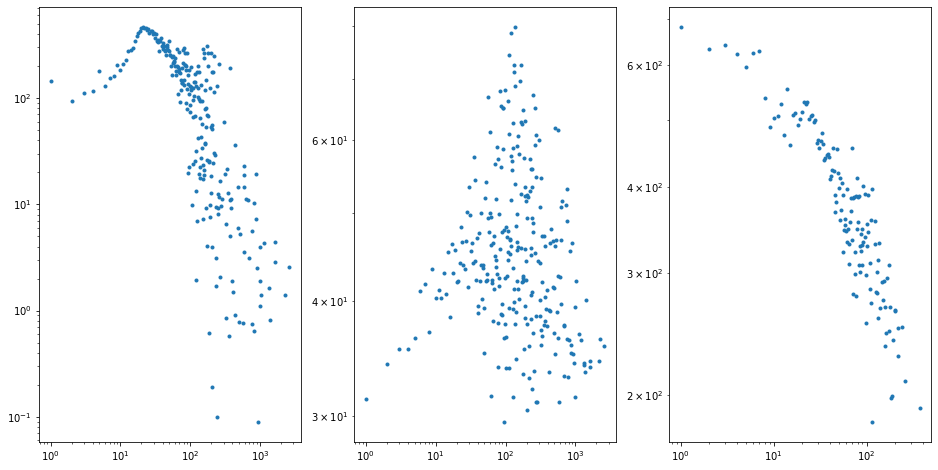

In [5]:
fig, ax = plt.subplots(1, 3, figsize=[16,8])
ax[0].loglog(k, k_nn, '.')
ax[1].loglog(k_in, k_nn_in, '.')
ax[2].loglog(k_out, k_nn_out, '.')

# Plotting

In [4]:
dg_plot = get_graph(req, cut=50, direction="in").to_undirected()
#posDG3D = nx.spring_layout(dg_plot, dim=3, k=1/np.sqrt(dg_plot.number_of_nodes())*10)

In [30]:
partition = {node: 1 for node in dg_plot.nodes()}
cmap = cm.get_cmap('Reds', max(partition.values()) + 1)
export_data(dg_plot, posDG3D, partition, cmap, step=None)

In [6]:
G, d_hoverinfo, d_nodecolors, d_nodesize, posG3D = read_data(f'../nodes_edges/nodes.csv',
                                                             f'../nodes_edges/edges.csv')
node_trace = get_trace_nodes_3D_legend(
                                  posG3D, 
                                  d_hoverinfo,
                                  d_nodecolors, 
                                  d_nodesize
)
edge_trace = get_trace_edges_3D(G, posG3D, color = '#C7C7C7', opac = 0.2, linewidth=0.2)

data = [*node_trace, edge_trace]

In [7]:
plot_3D(data,
        path='./plots/static', # set a folder of choice
        fname = 'static', # set a name for your plot file
        scheme='dark', # or 'light' = plot background choice 
       )

NameError: name 'data' is not defined

In [8]:
sorted(list(dg_plot.degree), key=lambda x: x[1], reverse=True)

[('pytest', 251),
 ('apache-airflow', 145),
 ('pytest-cov', 130),
 ('sphinx', 123),
 ('numpy', 118),
 ('requests', 117),
 ('six', 99),
 ('setuptools', 97),
 ('flake8', 93),
 ('coverage', 78),
 ('Sphinx', 74),
 ('sphinx-rtd-theme', 67),
 ('importlib-metadata', 66),
 ('datasets', 65),
 ('typing-extensions', 63),
 ('packaging', 63),
 ('pandas', 58),
 ('napari', 58),
 ('black', 55),
 ('tox', 55),
 ('mypy', 54),
 ('matplotlib', 52),
 ('scipy', 52),
 ('mock', 52),
 ('ipython', 48),
 ('dagster', 48),
 ('transformers', 46),
 ('pre-commit', 45),
 ('tensorflow-datasets', 41),
 ('optuna', 41),
 ('scikit-learn', 40),
 ('scikit-image', 40),
 ('web3', 40),
 ('pytz', 39),
 ('PyYAML', 39),
 ('click', 38),
 ('wheel', 38),
 ('python-dateutil', 38),
 ('twine', 37),
 ('wandb', 37),
 ('papermill', 37),
 ('cryptography', 36),
 ('docutils', 36),
 ('ray', 36),
 ('pytorch-lightning', 35),
 ('dash', 35),
 ('virtualenv', 34),
 ('holoviews', 34),
 ('isort', 33),
 ('aiohttp', 33),
 ('pytest-xdist', 33),
 ('panel',